# Import thư viện

In [ ]:
import os
import numpy as np
import pandas as pd
 
import seaborn as sn; sn.set(font_scale=1.4)        
import matplotlib.pyplot as plt             
import cv2                          
import tensorflow as tf                
import tqdm.notebook as tq
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,MaxPool2D,Add, Convolution2D, Rescaling
from keras.layers import BatchNormalization,AveragePooling2D,Activation
from sklearn.model_selection import train_test_split

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import layers, Model
import pickle
from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
import json

In [ ]:
try:
  if os.listdir('data_chotot'):
    pass
except:
  !unzip '/content/drive/MyDrive/Study/DL/BAI TAP LON/data_chotot.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: data_chotot/valid/CayCanh/0378684b3dbb596bdf651139df86f831-2739446993124739923.jpg  
  inflating: data_chotot/valid/CayCanh/138959d1ad9029337b60246a04dc008f-2740025617322957175.jpg  
  inflating: data_chotot/valid/CayCanh/14252d17d30ce9512969e77d902e8c23-2743870681376971744.jpg  
  inflating: data_chotot/valid/CayCanh/14369fbd265b333317486c7df990d15b-2743739585003949644.jpg  
  inflating: data_chotot/valid/CayCanh/1725922695bc10a4aec85be30b5ee3b9-2738133235875136227.jpg  
  inflating: data_chotot/valid/CayCanh/21148c08d798a66f723a32efd77ca3fa-2743446860880226281.jpg  
  inflating: data_chotot/valid/CayCanh/26300c816b08594761767b3fd831b3c1-2744021343742229472.jpg  
  inflating: data_chotot/valid/CayCanh/29768f3bdda534ecb93fde97e04a687e-2740165899321366484.jpg  
  inflating: data_chotot/valid/CayCanh/2996140e9879b4f815b75b6c6522b197-2737929382994276732.jpg  
  inflating: data_chotot/valid/CayCanh/31037859d08a02be6a3b98

In [ ]:
train_folder = "/content/data_chotot/train"
valid_folder = "/content/data_chotot/valid"
test_folder = "/content/data_chotot/test"
IMG_SIZE = 224
class_names = os.listdir(train_folder)

# Visualize dữ liệu

In [ ]:
images = []
labels = []
count_image = []
for i in os.listdir(valid_folder):
  labels.append(i)
  count_image.append(len(os.listdir(os.path.join(valid_folder, i))))
  for n in os.listdir(os.path.join(valid_folder, i)):
    img_path = os.path.join(valid_folder, i, n)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224)) 
    images.append(image)
    break
images = np.array(images, dtype = 'float32')
labels = np.array(labels)  

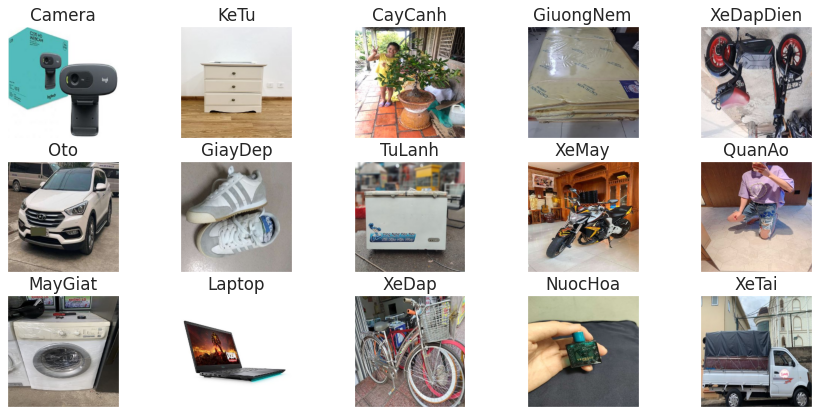

In [ ]:
fig,axes = plt.subplots(3,5,figsize=(15,7))
n = 0
for  i,ax in enumerate(axes.flat):
    i += 100
    img = images[n]/255
    label = labels[n]
    ax.set_title(str(label))
    ax.imshow(img, cmap ='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    n = n+1

In [ ]:
train_len = 0
for i in os.listdir(train_folder):
  train_len = train_len + len(os.listdir(os.path.join(train_folder, i)))
print("Train: ", train_len)

valid_len = 0
for i in os.listdir(valid_folder):
  valid_len = valid_len + len(os.listdir(os.path.join(valid_folder, i)))
print("valid: ", valid_len)

test_len = 0
for i in os.listdir(test_folder):
  test_len = test_len + len(os.listdir(os.path.join(test_folder, i)))
print("test: ", test_len)
print("Tổng: ", (train_len + valid_len + test_len))

Train:  51971
valid:  5775
test:  6417
Tổng:  64163


In [ ]:
data_count = []
for i in os.listdir(valid_folder):
  a = len(os.listdir(os.path.join(valid_folder, i)))
  b = len(os.listdir(os.path.join(train_folder, i)))
  c = len(os.listdir(os.path.join(test_folder, i)))
  
  data_count.append(a+b+c)

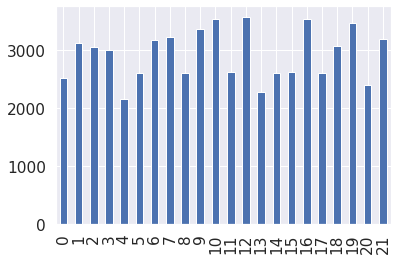

In [ ]:
pd.Series(data_count).plot(kind = 'bar')

# Xử lý dữ liệu

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
      rescale=1./255)
# Data flow
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=256,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 51971 images belonging to 22 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_folder,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=256,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 5775 images belonging to 22 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 6417 images belonging to 22 classes.


In [ ]:
def load_data(datasets, IMAGE_SIZE = (IMG_SIZE, IMG_SIZE)): 
    class_names = []
    for dataset in datasets:
        images = []
        labels = []  
        print("Tải lên {} với Image Size: {}".format(dataset,IMAGE_SIZE))      
        step = 0
        # max_image = 500
        for folder in os.listdir(dataset):
            n = 0
            if folder == '.ipynb_checkpoints':
              continue
            print("Đọc thư mục", str(folder),":")
            for file in tq.tqdm(os.listdir(os.path.join(dataset, folder))):
              img_path = os.path.join(os.path.join(dataset, folder), file)
              if img_path.split('.')[-1] != 'jpg':
                continue
              image = cv2.imread(img_path)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, IMAGE_SIZE) 
            
              images.append(image)
              labels.append(step)
              n = n + 1
              # if n>=max_image:
              #   break
            step += 1
            class_names.append(str(folder)) 

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
 
    return images, labels, class_names
IMAGE_SIZE = (IMG_SIZE, IMG_SIZE)
images, labels, class_names = load_data(['/content/data_chotot/test'])
print("Class names:",class_names)

Tải lên /content/data_chotot/test với Image Size: (224, 224)
Đọc thư mục Camera :


  0%|          | 0/254 [00:00<?, ?it/s]

Đọc thư mục KeTu :


  0%|          | 0/329 [00:00<?, ?it/s]

Đọc thư mục CayCanh :


  0%|          | 0/287 [00:00<?, ?it/s]

Đọc thư mục GiuongNem :


  0%|          | 0/277 [00:00<?, ?it/s]

Đọc thư mục XeDapDien :


  0%|          | 0/219 [00:00<?, ?it/s]

Đọc thư mục Oto :


  0%|          | 0/271 [00:00<?, ?it/s]

Đọc thư mục GiayDep :


  0%|          | 0/320 [00:00<?, ?it/s]

Đọc thư mục TuLanh :


  0%|          | 0/323 [00:00<?, ?it/s]

Đọc thư mục XeMay :


  0%|          | 0/249 [00:00<?, ?it/s]

Đọc thư mục QuanAo :


  0%|          | 0/338 [00:00<?, ?it/s]

Đọc thư mục MayGiat :


  0%|          | 0/336 [00:00<?, ?it/s]

Đọc thư mục Laptop :


  0%|          | 0/258 [00:00<?, ?it/s]

Đọc thư mục XeDap :


  0%|          | 0/349 [00:00<?, ?it/s]

Đọc thư mục NuocHoa :


  0%|          | 0/243 [00:00<?, ?it/s]

Đọc thư mục XeTai :


  0%|          | 0/262 [00:00<?, ?it/s]

Đọc thư mục DienThoai :


  0%|          | 0/267 [00:00<?, ?it/s]

Đọc thư mục MayLanh :


  0%|          | 0/338 [00:00<?, ?it/s]

Đọc thư mục MayTinhBang :


  0%|          | 0/273 [00:00<?, ?it/s]

Đọc thư mục DongHo :


  0%|          | 0/317 [00:00<?, ?it/s]

Đọc thư mục BanGhe :


  0%|          | 0/348 [00:00<?, ?it/s]

Đọc thư mục Amply :


  0%|          | 0/235 [00:00<?, ?it/s]

Đọc thư mục TuiVi :


  0%|          | 0/324 [00:00<?, ?it/s]

Class names: ['Camera', 'KeTu', 'CayCanh', 'GiuongNem', 'XeDapDien', 'Oto', 'GiayDep', 'TuLanh', 'XeMay', 'QuanAo', 'MayGiat', 'Laptop', 'XeDap', 'NuocHoa', 'XeTai', 'DienThoai', 'MayLanh', 'MayTinhBang', 'DongHo', 'BanGhe', 'Amply', 'TuiVi']


In [ ]:
test_images, xnn= train_test_split(images, test_size=0.01,shuffle = True, random_state=38)

In [ ]:
test_images = np.array(test_images)

In [ ]:
test_images.shape

(6352, 224, 224, 3)

In [ ]:
list_class = {15:'QuanAo',17:'TuiVi',2:'Camera',10:'MayGiat',21:'XeTai',19:'XeDapDien',16:'TuLanh',0:'Amply',4:'DienThoai',13:'NuocHoa',6:'GiayDep',11:'MayLanh',12:'MayTinhBang',18:'XeDap',7:'GiuongNem',14:'Oto',20:'XeMay',5:'DongHo',9:'Laptop',3:'CayCanh',1:'BanGhe',8:'KeTu'}


In [ ]:
def ve_Acc_Loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend(['loss','val_loss'])
  plt.show()
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['accuracy','val_accuracy'])
  plt.show()

# Model 1

In [ ]:
def createModel1():
  model=Sequential()

  #block1
  # model.add(Rescaling(1/255, input_shape = (IMG_SIZE, IMG_SIZE, 3)))
  model.add(Convolution2D(32,(3,3),activation='relu', padding='same', input_shape = (IMG_SIZE, IMG_SIZE, 3)))#, input_shape = (IMG_SIZE, IMG_SIZE, 3)

  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(512, (3,3), activation='relu'))
  #model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Flatten())
  model.add(Dropout(0.4))

  model.add(Dense(units=120, activation='relu'))
  model.add(Dense(units=22, activation='softmax'))

  optimizer = tf.optimizers.Adam()
  model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model
model1 = createModel1()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       7

In [ ]:
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
history_model1 = model1.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
203/203 [==============================] - 162s 796ms/step - loss: 2.7407 - acc: 0.1764 - val_loss: 2.3019 - val_acc: 0.3130
Epoch 2/20
203/203 [==============================] - 159s 780ms/step - loss: 2.0884 - acc: 0.3709 - val_loss: 1.9084 - val_acc: 0.4237
Epoch 3/20
203/203 [==============================] - 157s 774ms/step - loss: 1.7929 - acc: 0.4581 - val_loss: 1.6721 - val_acc: 0.4918
Epoch 4/20
203/203 [==============================] - 156s 768ms/step - loss: 1.6006 - acc: 0.5151 - val_loss: 1.4946 - val_acc: 0.5490
Epoch 5/20
203/203 [==============================] - 155s 765ms/step - loss: 1.4210 - acc: 0.5688 - val_loss: 1.3843 - val_acc: 0.5806
Epoch 6/20
203/203 [==============================] - 155s 761ms/step - loss: 1.3084 - acc: 0.6015 - val_loss: 1.2866 - val_acc: 0.6112
Epoch 7/20
203/203 [==============================] - 154s 757ms/step - loss: 1.1906 - acc: 0.6359 - val_loss: 1.2400 - val_acc: 0.6188
Epoch 8/20
203/203 [============================

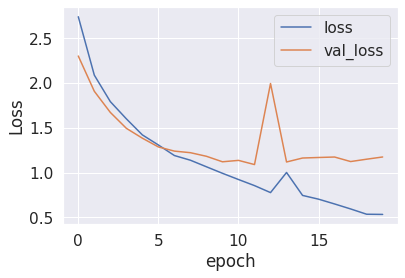

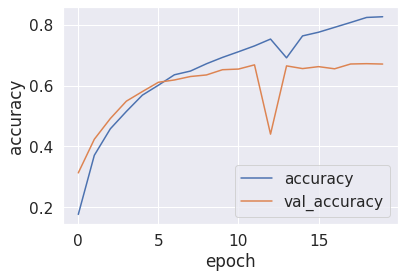

In [ ]:
ve_Acc_Loss(history_model1)

In [ ]:
model1.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/model1_best.h5')
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model1.json', 'w', encoding='utf-8') as f:
  json.dump(history_model1.history, f, ensure_ascii=False, indent=4)

In [ ]:
model1.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/model1_best.h5')

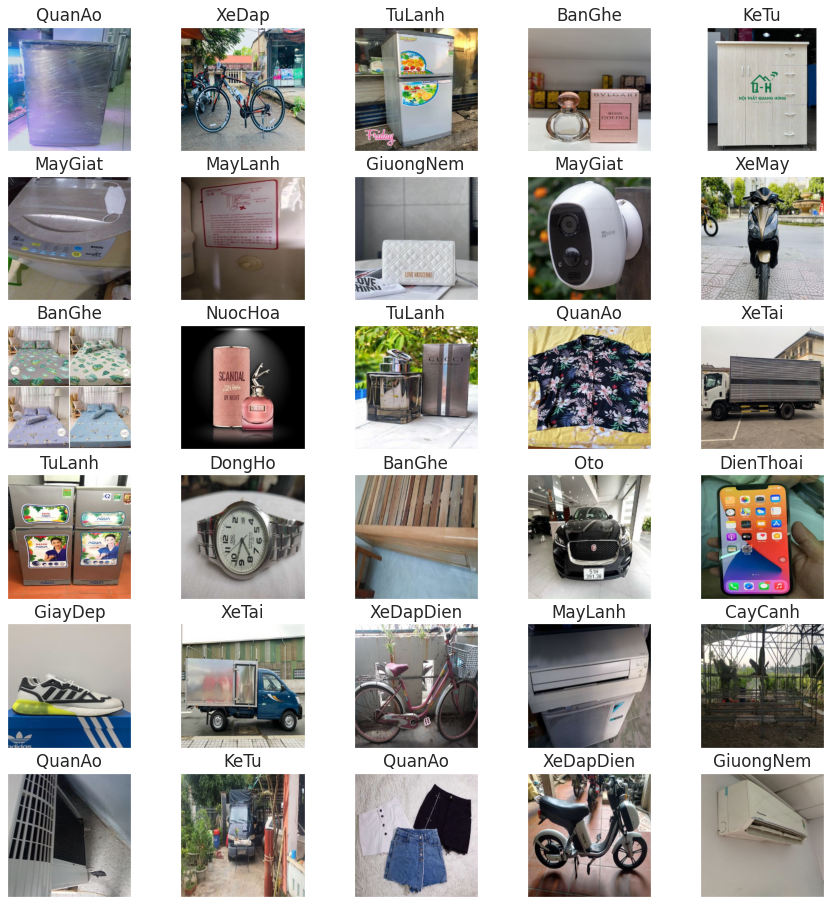

In [ ]:
def test_model(model):
  fig,axes = plt.subplots(6,5,figsize=(15,16))
  for i,ax in enumerate(axes.flat):
      i += 100
      img = test_images[i]/255
      ax.imshow(img, cmap ='gray')
      nn = model.predict(np.expand_dims(test_images[i]/255,0))[0]
      nn = np.argmax(nn)
      label = list_class[nn]
      ax.set_title(str(label))
      ax.set_xticks([])
      ax.set_yticks([])

test_model(model1)

# Xception

In [ ]:
def xception_model():
  xception_model = tf.keras.applications.Xception(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet', pooling='avg')

  xception_model.trainable = False
  model = tf.keras.models.Sequential()
  model.add(xception_model)
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
  model.summary()
  return model
xception_model = xception_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 22)               

In [ ]:
optimizer = tf.optimizers.Adam(0.0001)
xception_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
h = xception_model.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=15
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
203/203 [==============================] - 184s 887ms/step - loss: 1.3834 - acc: 0.6282 - val_loss: 0.6113 - val_acc: 0.8216
Epoch 2/15
203/203 [==============================] - 176s 865ms/step - loss: 0.7301 - acc: 0.7855 - val_loss: 0.5391 - val_acc: 0.8381
Epoch 3/15
203/203 [==============================] - 173s 849ms/step - loss: 0.6551 - acc: 0.8050 - val_loss: 0.5080 - val_acc: 0.8461
Epoch 4/15
203/203 [==============================] - 172s 844ms/step - loss: 0.6070 - acc: 0.8177 - val_loss: 0.4950 - val_acc: 0.8493
Epoch 5/15
203/203 [==============================] - 172s 847ms/step - loss: 0.5761 - acc: 0.8264 - val_loss: 0.4852 - val_acc: 0.8539
Epoch 6/15
203/203 [==============================] - 172s 847ms/step - loss: 0.5534 - acc: 0.8326 - val_loss: 0.4684 - val_acc: 0.8551
Epoch 7/15
203/203 [==============================] - 172s 845ms/step - loss: 0.5322 - acc: 0.8382 - val_loss: 0.4731 - val_acc: 0.8551
Epoch 8/15
203/203 [============================

In [ ]:
xception_model.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/xception_model_best.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_xception_best.json', 'w', encoding='utf-8') as f:
  json.dump(h.history, f, ensure_ascii=False, indent=4)

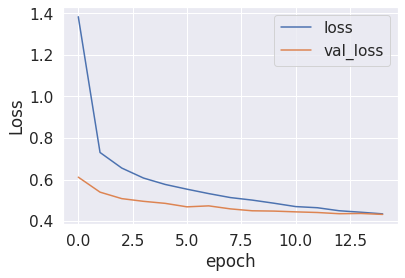

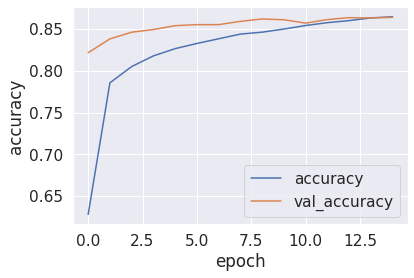

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.show()

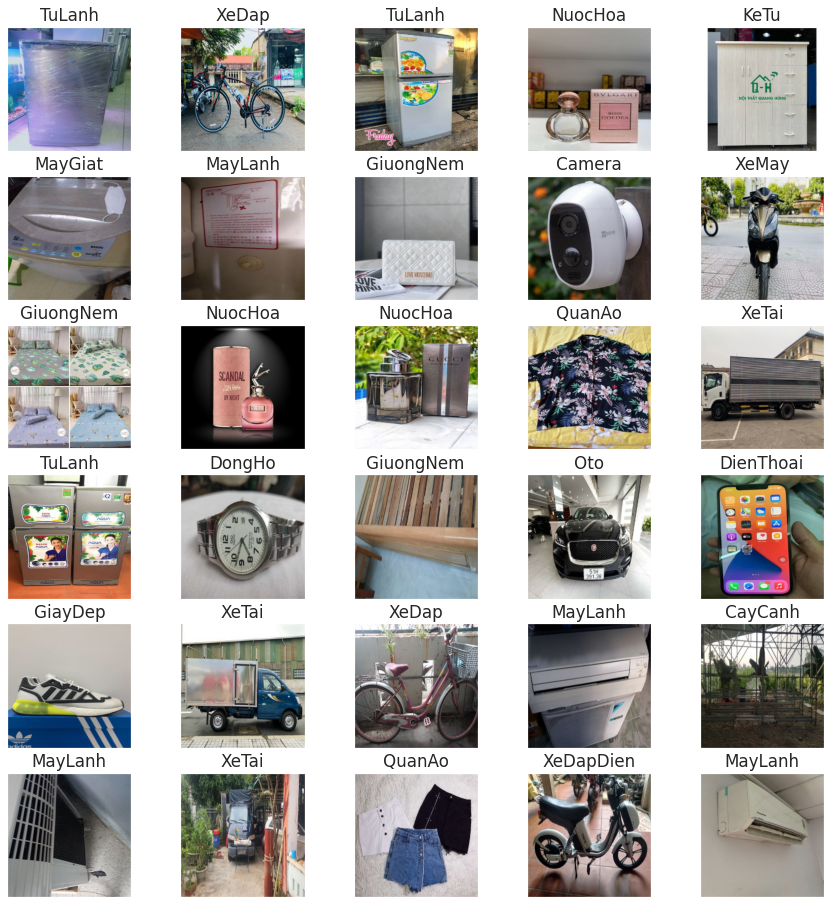

In [ ]:
xception_model.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/xception_model_best.h5')
test_model(xception_model)

# MobileNet

In [ ]:
def model_mobilenet():
  model_mobilenet = tf.keras.applications.MobileNet(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet', pooling='avg')
  model_mobilenet.trainable = False
  model = tf.keras.models.Sequential()
  model.add(model_mobilenet)
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
  model.summary()
  return model
  
model_mobilenet = model_mobilenet()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
optimizer = tf.optimizers.Adam()
model_mobilenet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
history_model_mobilenet = model_mobilenet.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=15
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
203/203 [==============================] - 156s 757ms/step - loss: 1.0451 - acc: 0.6851 - val_loss: 0.5097 - val_acc: 0.8438
Epoch 2/15
203/203 [==============================] - 153s 752ms/step - loss: 0.6294 - acc: 0.8082 - val_loss: 0.4679 - val_acc: 0.8485
Epoch 3/15
203/203 [==============================] - 152s 747ms/step - loss: 0.5416 - acc: 0.8336 - val_loss: 0.4830 - val_acc: 0.8446
Epoch 4/15
203/203 [==============================] - 152s 747ms/step - loss: 0.5076 - acc: 0.8440 - val_loss: 0.4454 - val_acc: 0.8576
Epoch 5/15
203/203 [==============================] - 151s 744ms/step - loss: 0.4713 - acc: 0.8538 - val_loss: 0.4232 - val_acc: 0.8681
Epoch 6/15
203/203 [==============================] - 153s 751ms/step - loss: 0.4511 - acc: 0.8598 - val_loss: 0.4249 - val_acc: 0.8695
Epoch 7/15
203/203 [==============================] - 151s 745ms/step - loss: 0.4506 - acc: 0.8603 - val_loss: 0.4117 - val_acc: 0.8722
Epoch 8/15
203/203 [============================

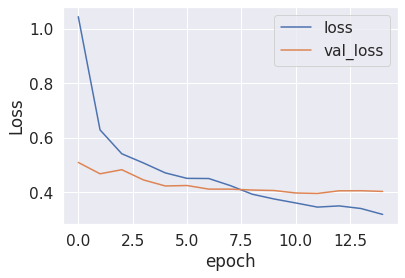

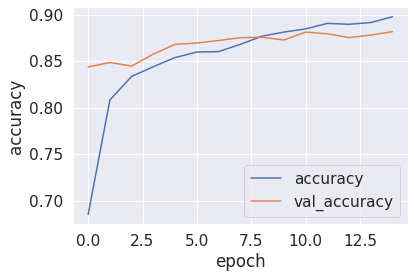

In [ ]:
ve_Acc_Loss(history_model_mobilenet)

In [ ]:
model_mobilenet.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_mobilenet_best.h5')
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_mobilenet_best.json', 'w', encoding='utf-8') as f:
  json.dump(history_model_mobilenet.history, f, ensure_ascii=False, indent=4)

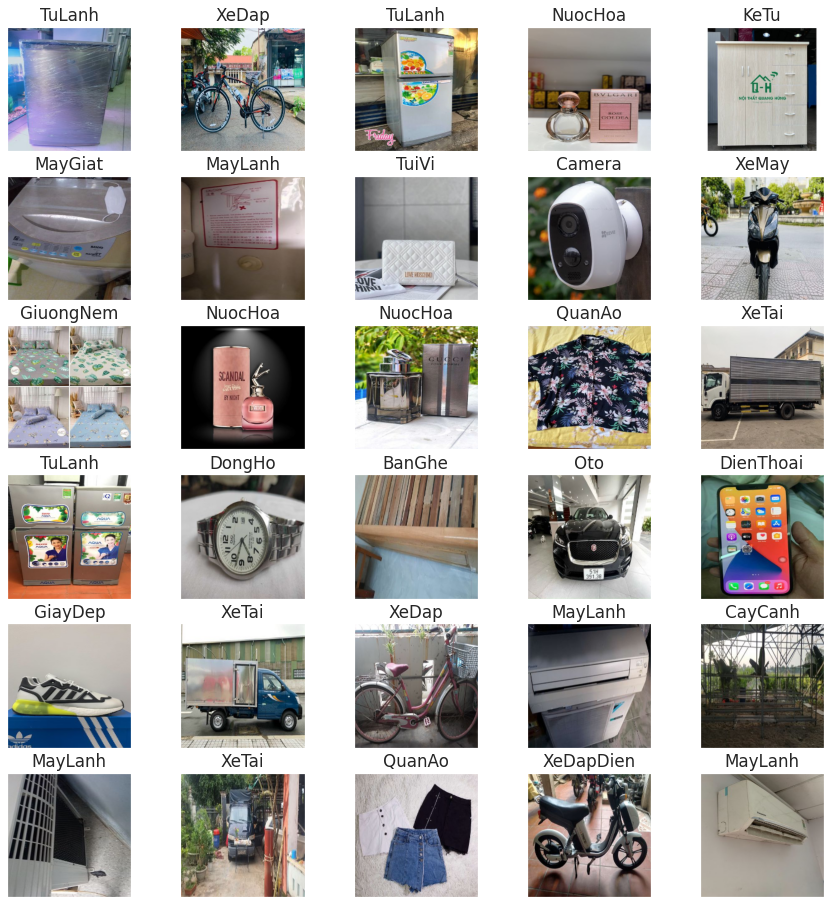

In [ ]:
model_mobilenet.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_mobilenet_best.h5')
test_model(model_mobilenet)

# InceptionV3

In [ ]:
def model_InceptionV3():

  model_InceptionV3 = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet', pooling='avg')

  model_InceptionV3.trainable = False
  model = tf.keras.models.Sequential()
  model.add(model_InceptionV3)
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
  model.summary()
  return model

model_InceptionV3 = model_InceptionV3()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 22)               

In [ ]:
optimizer = tf.optimizers.Adam()
model_InceptionV3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
history_model_InceptionV3 = model_InceptionV3.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=15
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
203/203 [==============================] - 174s 826ms/step - loss: 0.9521 - acc: 0.7228 - val_loss: 0.5647 - val_acc: 0.8276
Epoch 2/15
203/203 [==============================] - 159s 782ms/step - loss: 0.6296 - acc: 0.8101 - val_loss: 0.5469 - val_acc: 0.8248
Epoch 3/15
203/203 [==============================] - 156s 770ms/step - loss: 0.5651 - acc: 0.8267 - val_loss: 0.4992 - val_acc: 0.8453
Epoch 4/15
203/203 [==============================] - 157s 772ms/step - loss: 0.5280 - acc: 0.8379 - val_loss: 0.4959 - val_acc: 0.8471
Epoch 5/15
203/203 [==============================] - 155s 765ms/step - loss: 0.4979 - acc: 0.8467 - val_loss: 0.4804 - val_acc: 0.8523
Epoch 6/15
203/203 [==============================] - 155s 763ms/step - loss: 0.4789 - acc: 0.8513 - val_loss: 0.4802 - val_acc: 0.8519
Epoch 7/15
203/203 [==============================] - 155s 763ms/step - loss: 0.4629 - acc: 0.8561 - val_loss: 0.4745 - val_acc: 0.8546
Epoch 8/15
203/203 [============================

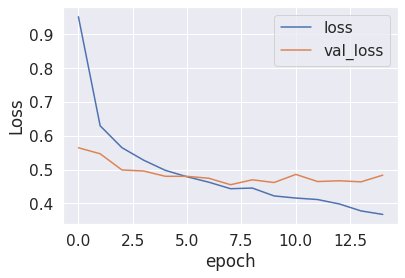

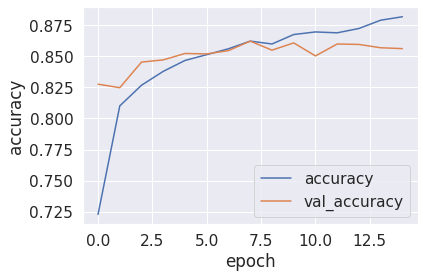

In [ ]:
ve_Acc_Loss(history_model_InceptionV3)

In [ ]:
model_InceptionV3.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_InceptionV3_best.h5')
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_InceptionV3_best.json', 'w', encoding='utf-8') as f:
  json.dump(history_model_InceptionV3.history, f, ensure_ascii=False, indent=4)

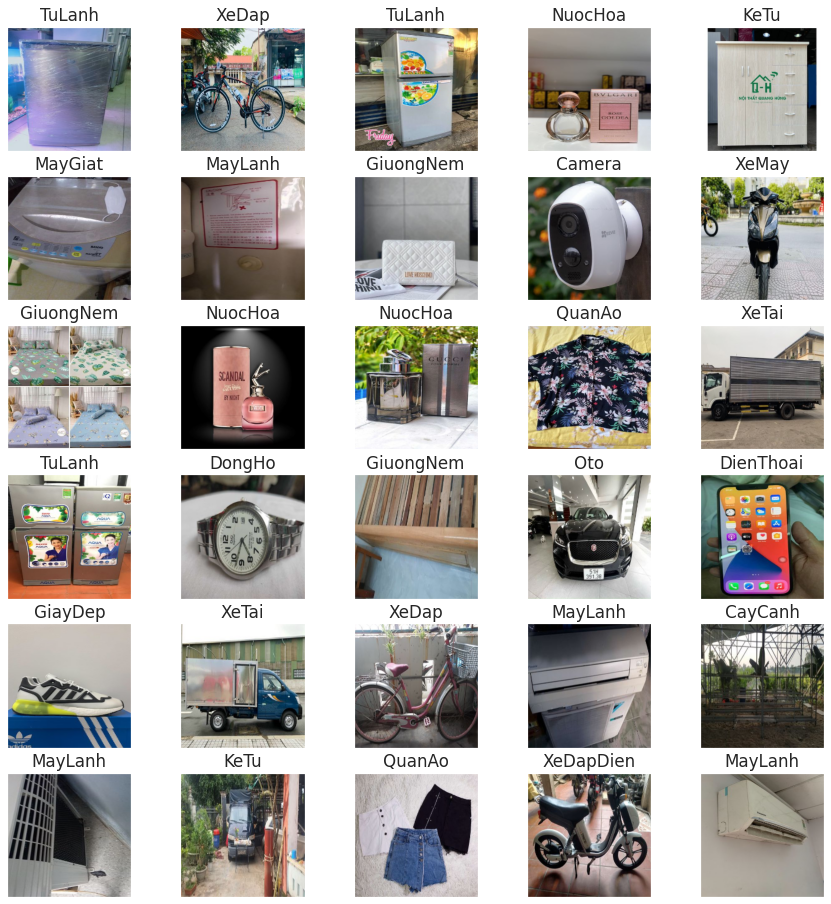

In [ ]:
model_InceptionV3.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_InceptionV3_best.h5')
test_model(model_InceptionV3)

# DenseNet121

In [ ]:
def model_DenseNet121():
  model_DenseNet121 = tf.keras.applications.DenseNet121(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False, weights='imagenet', pooling='avg')
  model_DenseNet121.trainable = False

  model = tf.keras.models.Sequential()
  model.add(model_DenseNet121)
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
  
  model.summary()
  return model
  
model_DenseNet121 = model_DenseNet121()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 22)               

In [ ]:
optimizer = tf.optimizers.Adam()
model_DenseNet121.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
history_model_DenseNet121 = model_DenseNet121.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
203/203 [==============================] - 169s 796ms/step - loss: 1.0283 - acc: 0.6907 - val_loss: 0.5156 - val_acc: 0.8359
Epoch 2/20
203/203 [==============================] - 158s 775ms/step - loss: 0.6519 - acc: 0.7986 - val_loss: 0.4769 - val_acc: 0.8542
Epoch 3/20
203/203 [==============================] - 157s 772ms/step - loss: 0.5936 - acc: 0.8143 - val_loss: 0.4487 - val_acc: 0.8642
Epoch 4/20
203/203 [==============================] - 158s 777ms/step - loss: 0.5483 - acc: 0.8306 - val_loss: 0.4455 - val_acc: 0.8624
Epoch 5/20
203/203 [==============================] - 158s 777ms/step - loss: 0.5426 - acc: 0.8289 - val_loss: 0.4284 - val_acc: 0.8674
Epoch 6/20
203/203 [==============================] - 157s 771ms/step - loss: 0.5033 - acc: 0.8430 - val_loss: 0.4230 - val_acc: 0.8732
Epoch 7/20
203/203 [==============================] - 157s 775ms/step - loss: 0.4871 - acc: 0.8483 - val_loss: 0.4126 - val_acc: 0.8739
Epoch 8/20
203/203 [============================

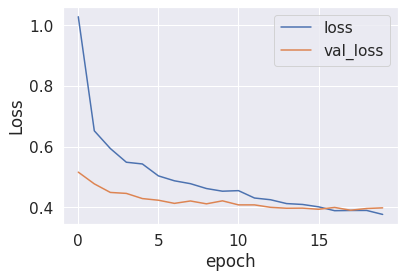

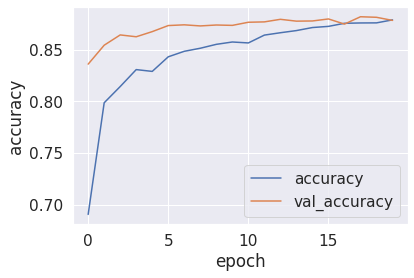

In [ ]:
ve_Acc_Loss(history_model_DenseNet121)

In [ ]:
model_DenseNet121.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_DenseNet121.h5')
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_DenseNet121.json', 'w', encoding='utf-8') as f:
  json.dump(history_model_DenseNet121.history, f, ensure_ascii=False, indent=4)

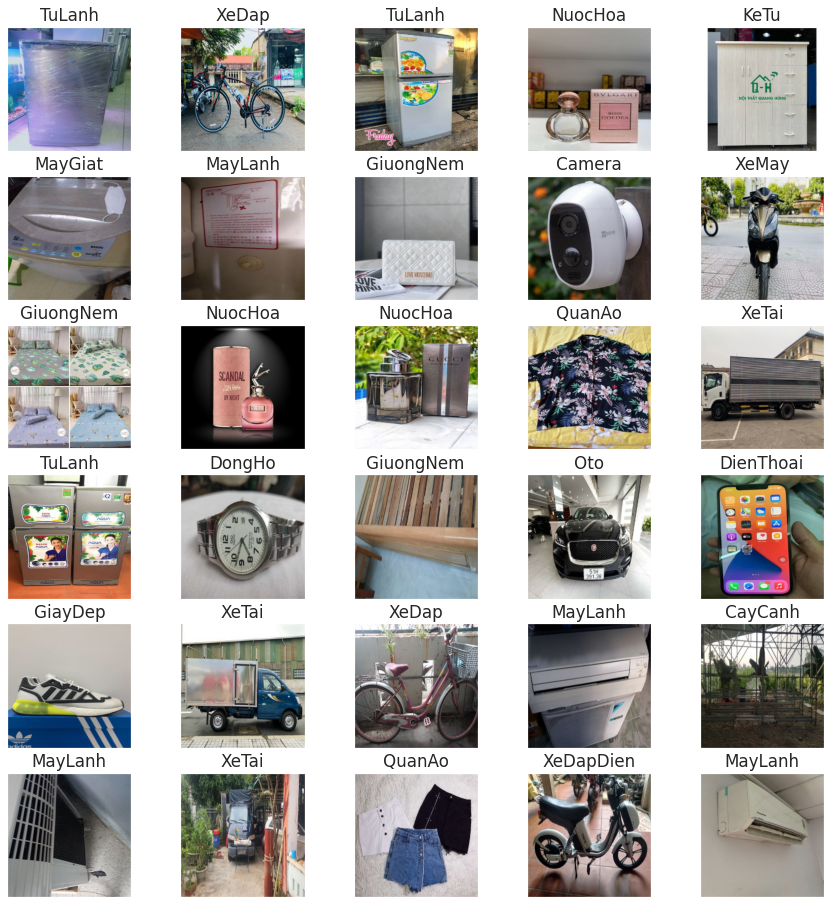

In [ ]:
model_DenseNet121.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/model_DenseNet121.h5')
test_model(model_DenseNet121)

# VGG16

In [ ]:
def vgg16_model():

  vgg16_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet', pooling='avg')

  vgg16_model.trainable = False
  model = tf.keras.models.Sequential()
  model.add(vgg16_model)
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
  model.summary()
  return model

vgg16_model = vgg16_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 22)               

In [ ]:
optimizer = tf.optimizers.Adam()
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size
history_vgg16_model = vgg16_model.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    epochs=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
203/203 [==============================] - 175s 854ms/step - loss: 1.9901 - acc: 0.3979 - val_loss: 1.1574 - val_acc: 0.6635
Epoch 2/20
203/203 [==============================] - 165s 811ms/step - loss: 1.3218 - acc: 0.5908 - val_loss: 0.9960 - val_acc: 0.7040
Epoch 3/20
203/203 [==============================] - 165s 811ms/step - loss: 1.1897 - acc: 0.6321 - val_loss: 0.9216 - val_acc: 0.7235
Epoch 4/20
203/203 [==============================] - 163s 803ms/step - loss: 1.1337 - acc: 0.6477 - val_loss: 0.8961 - val_acc: 0.7326
Epoch 5/20
203/203 [==============================] - 161s 794ms/step - loss: 1.0960 - acc: 0.6623 - val_loss: 0.8651 - val_acc: 0.7386
Epoch 6/20
203/203 [==============================] - 163s 803ms/step - loss: 1.0505 - acc: 0.6761 - val_loss: 0.8268 - val_acc: 0.7496
Epoch 7/20
203/203 [==============================] - 163s 802ms/step - loss: 1.0438 - acc: 0.6765 - val_loss: 0.8265 - val_acc: 0.7496
Epoch 8/20
203/203 [============================

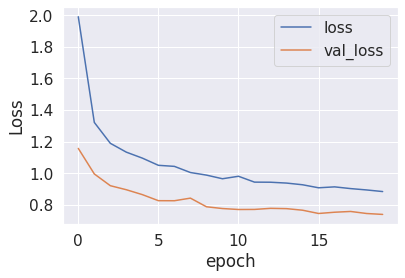

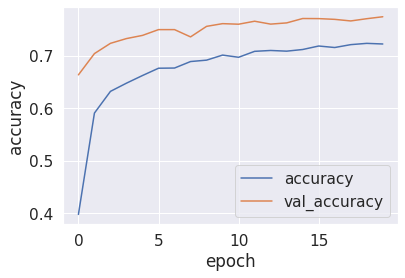

In [ ]:
ve_Acc_Loss(history_vgg16_model)

In [ ]:
vgg16_model.save('/content/drive/MyDrive/Study/DL/BAI TAP LON/vgg16_model.h5')
with open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_vgg16_model.json', 'w', encoding='utf-8') as f:
  json.dump(history_vgg16_model.history, f, ensure_ascii=False, indent=4)

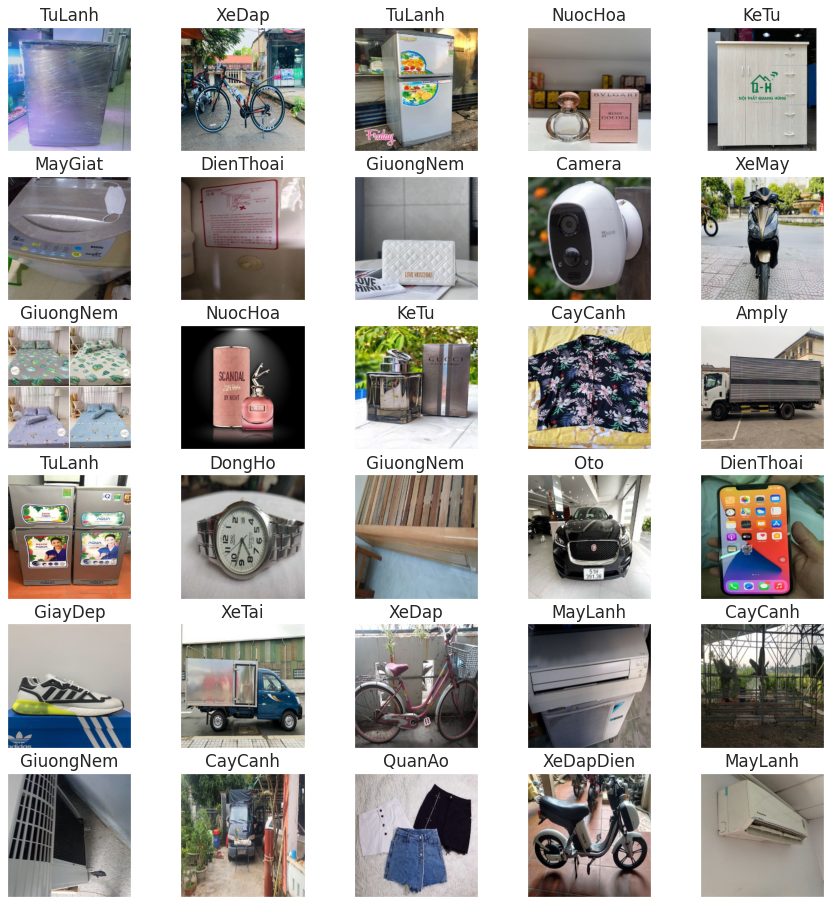

In [ ]:
vgg16_model.load_weights('/content/drive/MyDrive/Study/DL/BAI TAP LON/vgg16_model.h5')
test_model(vgg16_model)

# Đánh giá

In [ ]:
n_test_steps = test_generator.n
test_generator.reset()
y_pred = model1.predict_generator(test_generator,
steps=n_test_steps,
verbose=1)

  24/6417 [..............................] - ETA: 28s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


6417/6417 [==============================] - 28s 4ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_class = [labels[k] for k in y_pred]

6417

In [ ]:
f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model1.json',)
history_model1 = json.load(f)

f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_xception_best.json',)
history_Xception = json.load(f)

f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_mobilenet_best.json',)
history_MobileNet = json.load(f)

f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_InceptionV3_best.json',)
history_InceptionV3 = json.load(f)

f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_vgg16_model.json',)
history_VGG16 = json.load(f)

f = open('/content/drive/MyDrive/Study/DL/BAI TAP LON/history_model_DenseNet121.json',)
history_DenseNet = json.load(f)

In [ ]:
acc = []
loss = []
name_model = []
def Acc_Loss(history, name):
  i = len(history['val_acc'])
  acc.append(history['val_acc'][i-1])
  loss.append(history['val_loss'][i-1])
  name_model.append(name)
  
Acc_Loss(history_model1, 'model 1')
Acc_Loss(history_Xception, 'Xception')
Acc_Loss(history_MobileNet, 'MobileNet')
Acc_Loss(history_InceptionV3, 'InceptionV3')
Acc_Loss(history_VGG16, 'VGG16')
Acc_Loss(history_DenseNet, 'DenseNet')

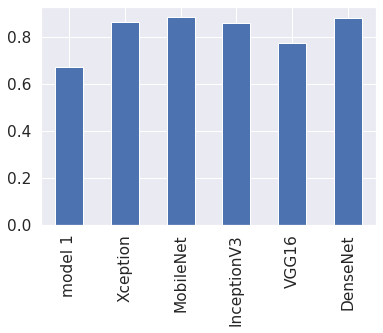

In [ ]:
pd.Series(acc, name_model).plot(kind = 'bar')

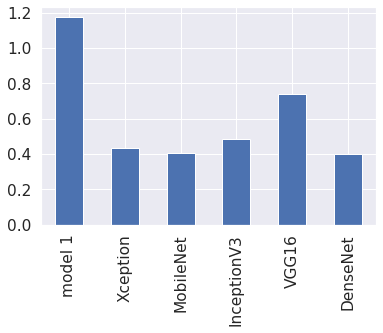

In [ ]:
pd.Series(loss, name_model).plot(kind = 'bar')